# **Harmful Algal Bloom Occurence Rate Over Time**

Specify the directory for the notebook, make sure data is in folder as well

In [1]:
import os
os.chdir(r'C:\Users\mbido\OneDrive\Documents\ESCI 796')
print(os.getcwd())



C:\Users\mbido\OneDrive\Documents\ESCI 796


## Introduction: 
    Harmful algal blooms result when excess nutrient (Phosphorous and Nitrogen) loading in water bodies combine with slow moving water and sunlight to create blue green algae which combine into Harmful Algal Blooms (HABs). There are many different types of blooms. Almost all have a negative impact on the surrounding environment, and many can be harmful to humans.


## Hypothesis:
    One of the main factors in HAB formation is energy availability. In the wake of climate change, nations have taken moves to curb emissions and lower global temperatures. Are these steps readily obvious when viewing HAB occurence rate? Evapotranspiration is another process reliant on water, would the rate of this over change time? And how will the potential changes compare to those of the HABs? Energy is a major source needed in facilitating both ET and HAB occurence, so how might the rates of these compare over the years?

## Studied Site:
For this project, the state of New York will be looked at. To estimate ET, a USGS gauge and NOAA gauge near Little Falls, NY provide information on discharge and precipitation.

## Datasets: 
1. Harmful_Algal_Bloom_Statewide_Occurrence_Summary__2012-2018.csv - Compiled by State of New York, provides info on HAB occurences throughout the state for a certain time period. Gives info on where the HAB occurred, and how long it was on DEC watchlists for.

2. 3263069.csv - A precipitation file from the USGS. Gives snow and precipitation data for a certain time period.

3. Littlefalls.txt - A text file from NOAA. Gives discharge data for the Mohawk River near Little Falls, NY.

### Load in the data files
Load and initially clean the data 

Text(0.5, 1.0, 'Combined Precipitation')

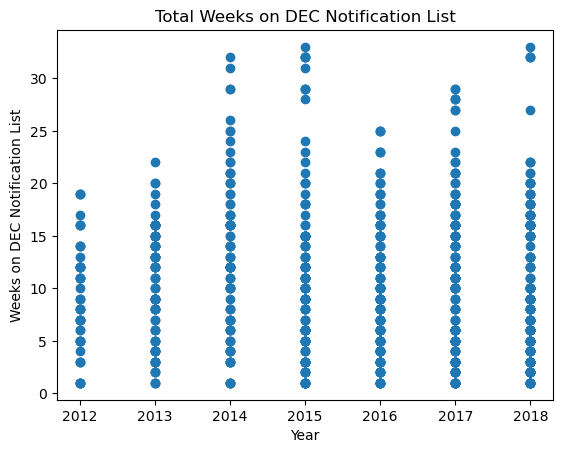

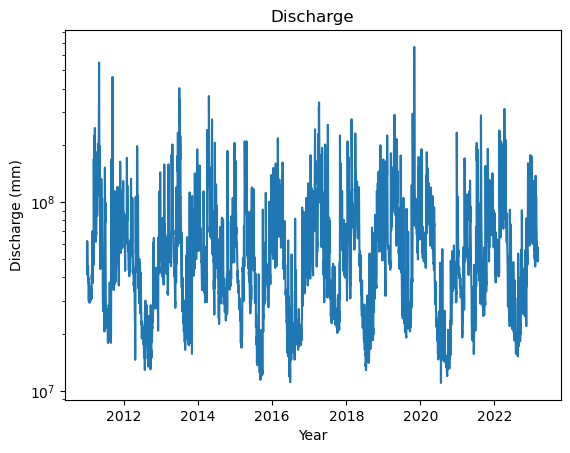

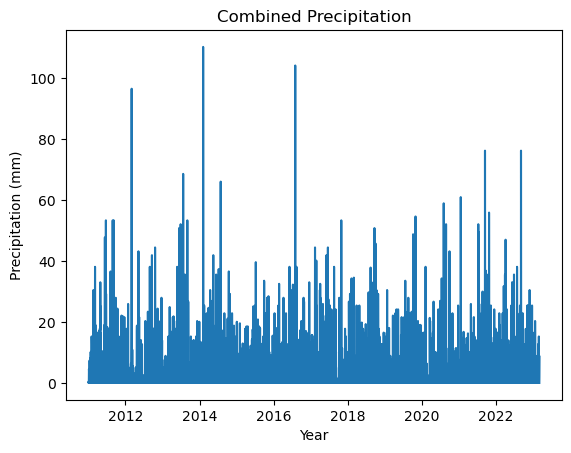

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
duration = 7

#%% Load in HAB data
# Load in the HAB data
dfhab = pd.read_csv('HAB data.csv', parse_dates=['Year'], index_col='Year')

#%% Load in discharge file
# Drainage area flowing into gauge point
drainage = 1342

# Load in the file, set Date as index
dfdis = pd.read_csv('Littlefalls.txt', comment = "#", delimiter='\t', header = 1,
                     parse_dates=['20d'], index_col=['20d'])

# Drop unused columns
dfdis.drop(columns = {"5s", "15s", "10s"}, inplace = True)

# Fill in missing values
dfdis.interpolate(method = 'linear')

# Convert the discharge value
dfdis["Discharge_mm"] = (dfdis["14n"]/drainage) * 26334720   #to mm/day

# Drop old column
dfdis.drop(columns = {"14n"}, inplace = True)

#%% Load in precip file
#Load in the file
dfp = pd.read_csv('3263069.csv', parse_dates=['DATE'], index_col=['DATE'])

# Fill missing values with 0
dfp = dfp.fillna(0)

# See if MDPR data exists
if 'MDPR' in dfp.columns.tolist():
     dfp['Combined'] = dfp['MDPR'] + dfp['PRCP']
else:
    dfp['Combined'] = dfp['PRCP']

#Convert to mm
dfp["Combined_Precip_mm"] = dfp["Combined"] * 25.4

#Delete old dataframes
dfp = dfp[['Combined_Precip_mm']]

#%% Initial Plots

fig1, ax1 = plt.subplots()
ax1.scatter(dfhab.index, dfhab['Number of Weeks on DEC Notification List'], label = 'Weeks on DEC List')
ax1.set_xlabel('Year')
ax1.set_ylabel('Weeks on DEC Notification List')
ax1.set_title('Total Weeks on DEC Notification List')

fig2, ax2 = plt.subplots()
ax2.plot(dfdis.index, dfdis['Discharge_mm'], label = 'Discharge (mm)')
ax2.set_yscale('log')
ax2.set_xlabel('Year')
ax2.set_ylabel('Discharge (mm)')
ax2.set_title('Discharge')

fig3, ax3 = plt.subplots()
ax3.plot(dfp.index, dfp['Combined_Precip_mm'], label = 'Precip (mm)',)
ax3.set_xlabel('Year')
ax3.set_ylabel('Precipitation (mm)')
ax3.set_title('Combined Precipitation')

## Results


Perform Calculations (and figure out why ET so messed up)

In [3]:
#%% Perform Calculations

dfyear = pd.DataFrame()

dfyear['Discharge_mm'] = dfdis['Discharge_mm'].resample('Y').mean()

dfyear['Combined_Precip_mm'] = dfp['Combined_Precip_mm'].resample('Y').mean()

#Sum of precip
precip = sum(dfyear['Combined_Precip_mm'])

#Avg annual Precip
ap = precip / duration

#Prints avg annual precip
print(f'The average annual precipitation is {ap} mm/yr')

#Sum discharge
discharge = sum(dfyear['Discharge_mm'])

#Avg annual discharge
ad = discharge / duration

#Prints avg annual discharge
print(f'The average annual discharge is {ad} mm/yr')

#Average annual evapo
et = (precip - discharge) / duration

#Prints avg annual evapotranspiration
print(f'The average annual evapotranspiration is around {et} mm/yr')

#Runoff coefficient
rc = (discharge / precip)  

#Prints the RC
print(f'The runoff coefficient is {rc}%')

The average annual precipitation is 6.650704827591698 mm/yr
The average annual discharge is 116643352.67528471 mm/yr
The average annual evapotranspiration is around -116643346.02457988 mm/yr
The runoff coefficient is 17538494.89626541%


Sort the HAB data by lake

In [4]:
#%% Look at different Lakes

dflake = dfhab.sort_values('Waterbody Name', axis = 0)

dflake['Year'] = dflake.index.year

#Remove column
dflake.drop(columns = {"Date of First Listing", "Date of Last Listing", "Number of Weeks with Updates", "Latitude", "Longitude", "Location 1", "Column1", "Column2"}, inplace = True)

 # Sort the index
dflake = dflake.sort_index()

Create dictionaries which contain dataframes of HAB data stored by DEC region and year

In [5]:
#%% Sort by region and year

# Get a list of all unique lake names
lake_names = dflake['Waterbody Name'].unique()

# Create an empty dictionary to store the dataframes
lake_dict = {}

# Loop through the lake names and create a dataframe for each lake
for lake in lake_names:
    # Get the data for the current lake
    lake_data = dflake[dflake['Waterbody Name'] == lake]
    
    # Add the data to the dictionary with the lake name as the key
    lake_dict[lake] = lake_data.copy()
    
# Get a list of all unique DEC regions
dec_regions = dflake['DEC Region'].unique()

# Create an empty dictionary to store the dataframes
region_dict = {}

regions = dflake['DEC Region'].unique

# Loop through the DEC regions and create a dataframe for each region
for region in dec_regions:
    # Get the data for the current region
    df_regional = dflake[dflake['DEC Region'] == region]
      
    # Sort the index
   # df_regional = df_regional.sort_index()
    
    # Store the data with the region name as the key
    region_dict[region] = df_regional.copy()
      
# Get a list of all unique years
years = dflake['Year'].unique()

# Create an empty dictionary to store the dataframes
yearly_dict = {}

# Loop through the years and create a dataframe for each year
for year in years:
    # Get the data for the current year
    df_yearly = dflake[dflake['Year'] == year]
    
    # Sum up the total number of weeks on the DEC notification list by region
    df_yearly_region = df_yearly.groupby('DEC Region')['Number of Weeks on DEC Notification List'].sum().reset_index()
    
    # Store the data with the year as the key
    yearly_dict[year] = df_yearly_region.copy()

Create a multi-panel plot with time as the x and HAB occurences on the y, with the plots differing from region to region (need to fix)

Text(0, 0.5, 'Region 9')

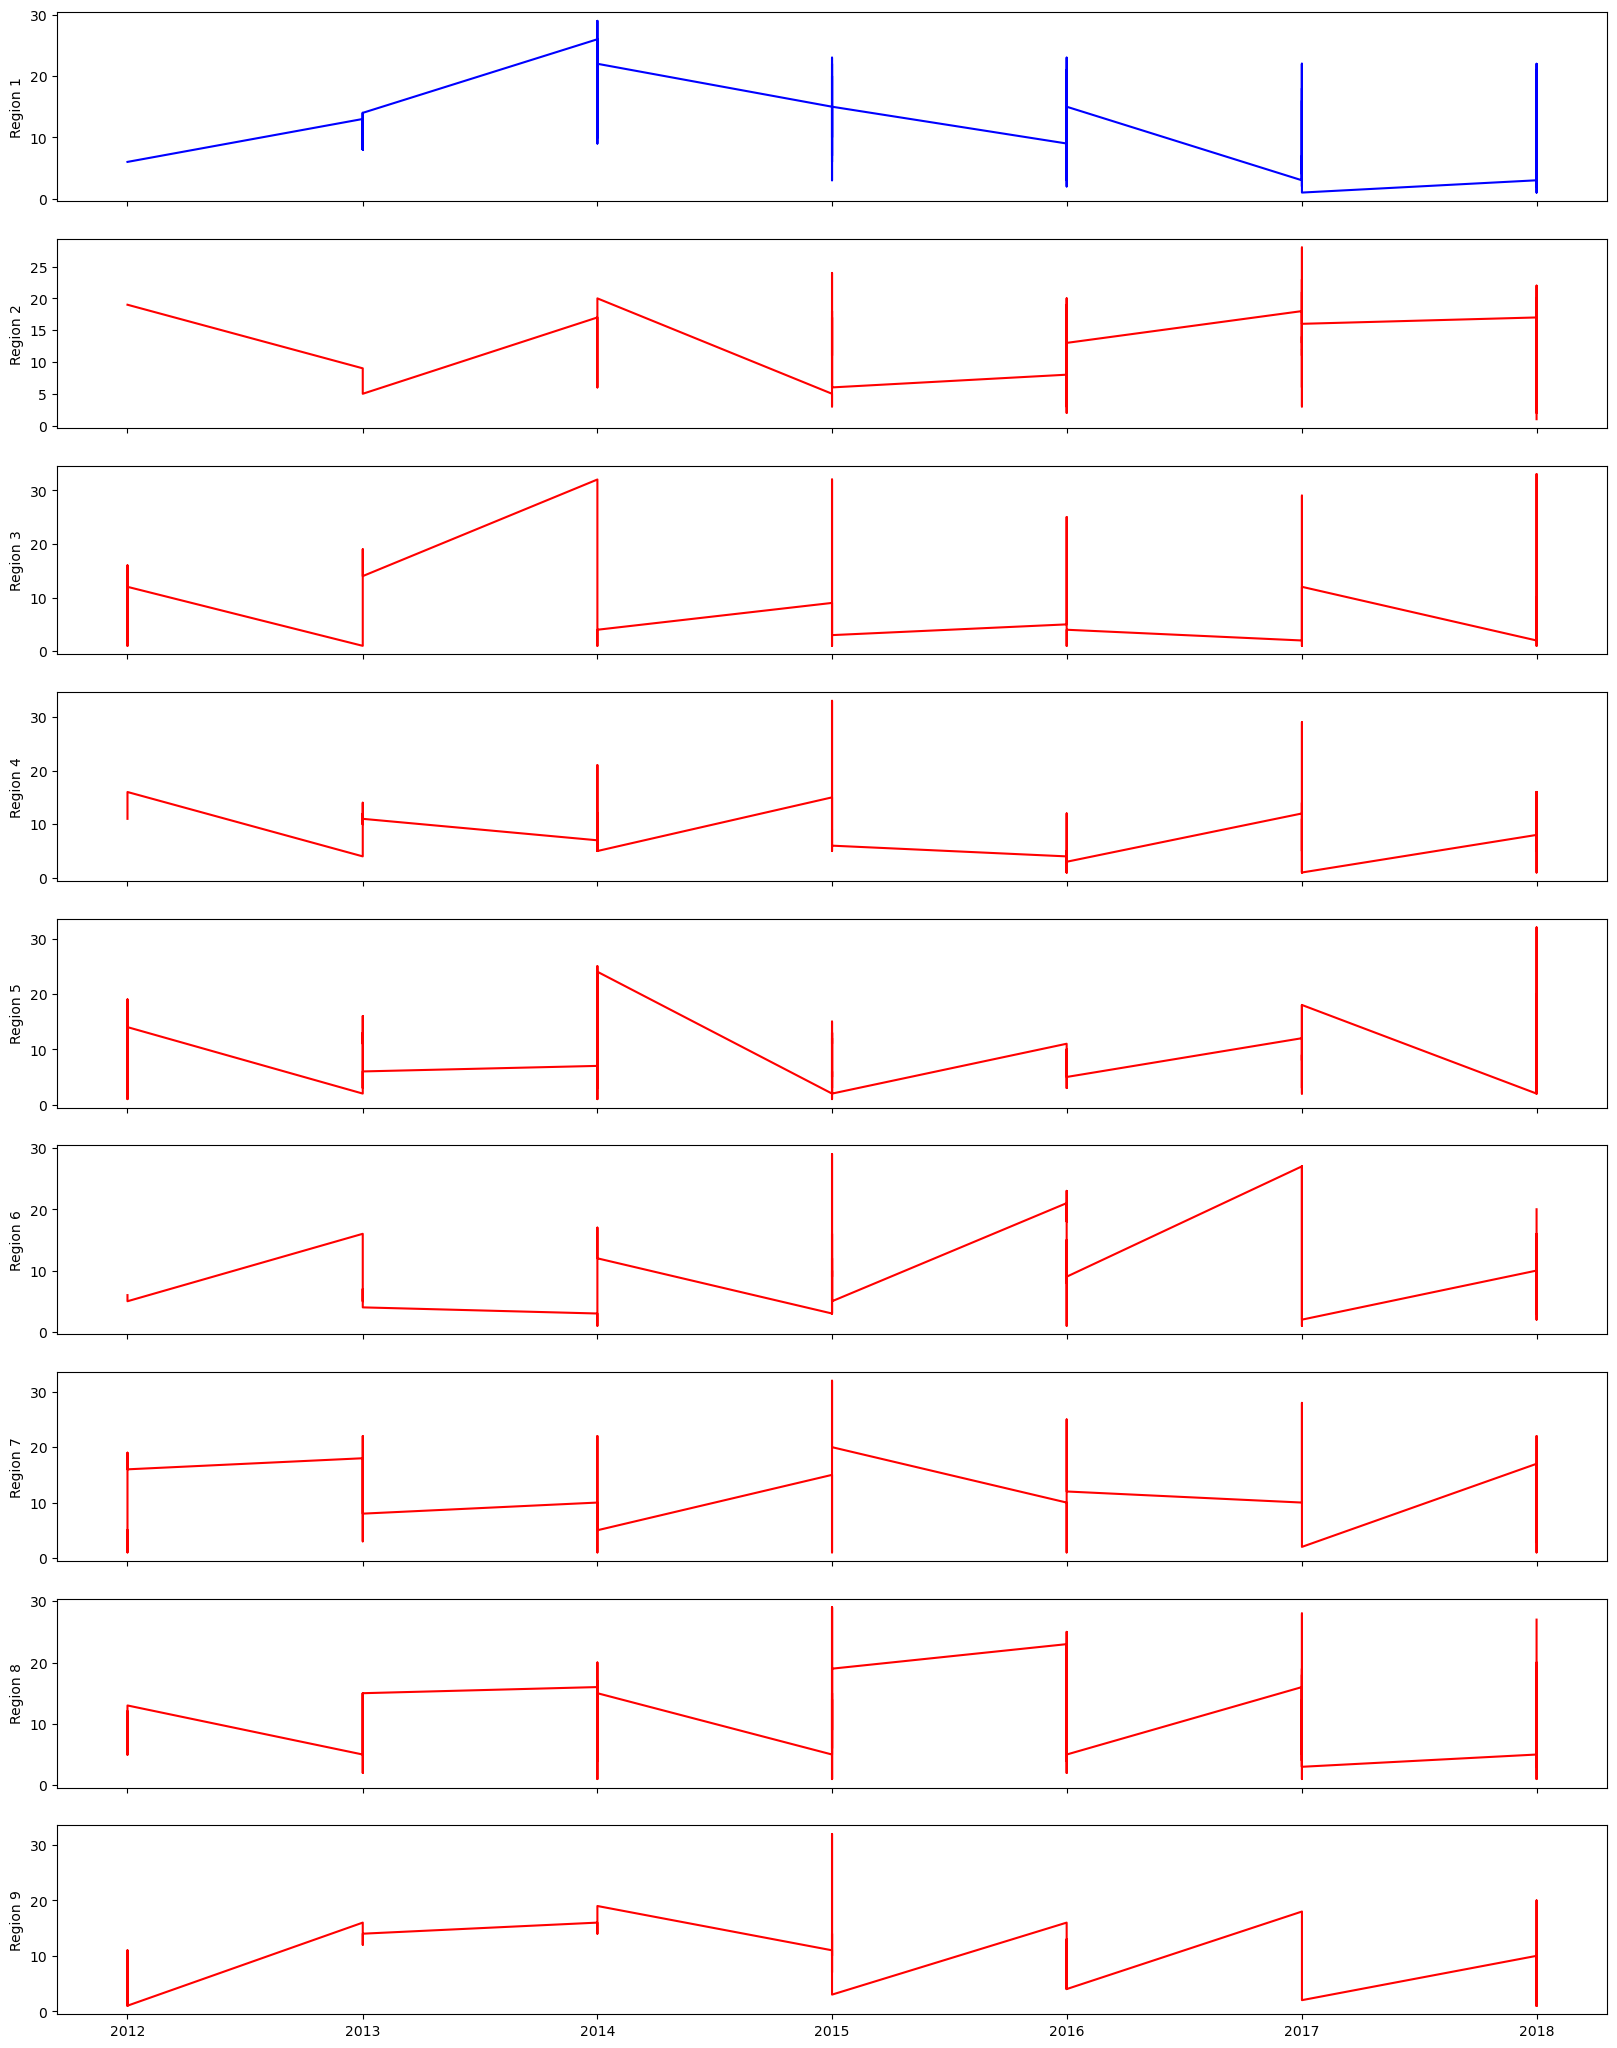

In [6]:
#%% Create multi-panel plot with each DEC region, per year

fig4, (ax14, ax24, ax34, ax44, ax54, ax64, ax74, ax84, ax94) = plt.subplots(9, 1,figsize = (20,26),sharex= True)

dfdec1 = region_dict[1]

ax14.plot(dfdec1['Number of Weeks on DEC Notification List'], 'b-', label = 'Region 1')
ax14.set_ylabel('Region 1')

dfdec2 = region_dict[2]

ax24.plot(dfdec2['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 2')
ax24.set_ylabel('Region 2')

dfdec3 = region_dict[3]

ax34.plot(dfdec3['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 3')
ax34.set_ylabel('Region 3')

dfdec4 = region_dict[4]

ax44.plot(dfdec4['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 4')
ax44.set_ylabel('Region 4')

dfdec5 = region_dict[5]

ax54.plot(dfdec5['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 5')
ax54.set_ylabel('Region 5')

dfdec6 = region_dict[6]

ax64.plot(dfdec6['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 6')
ax64.set_ylabel('Region 6')

dfdec7 = region_dict[7]

ax74.plot(dfdec7['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 7')
ax74.set_ylabel('Region 7')

dfdec8 = region_dict[8]

ax84.plot(dfdec8['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 8')
ax84.set_ylabel('Region 8')

dfdec9 = region_dict[9]

ax94.plot(dfdec9['Number of Weeks on DEC Notification List'], 'r-', label = 'Region 9')
ax94.set_ylabel('Region 9')

Create a multi-panel plot with DEC Region as the x and HAB occurences on the y, with the plots differing from year to year

Text(0.5, 0, 'DEC Region')

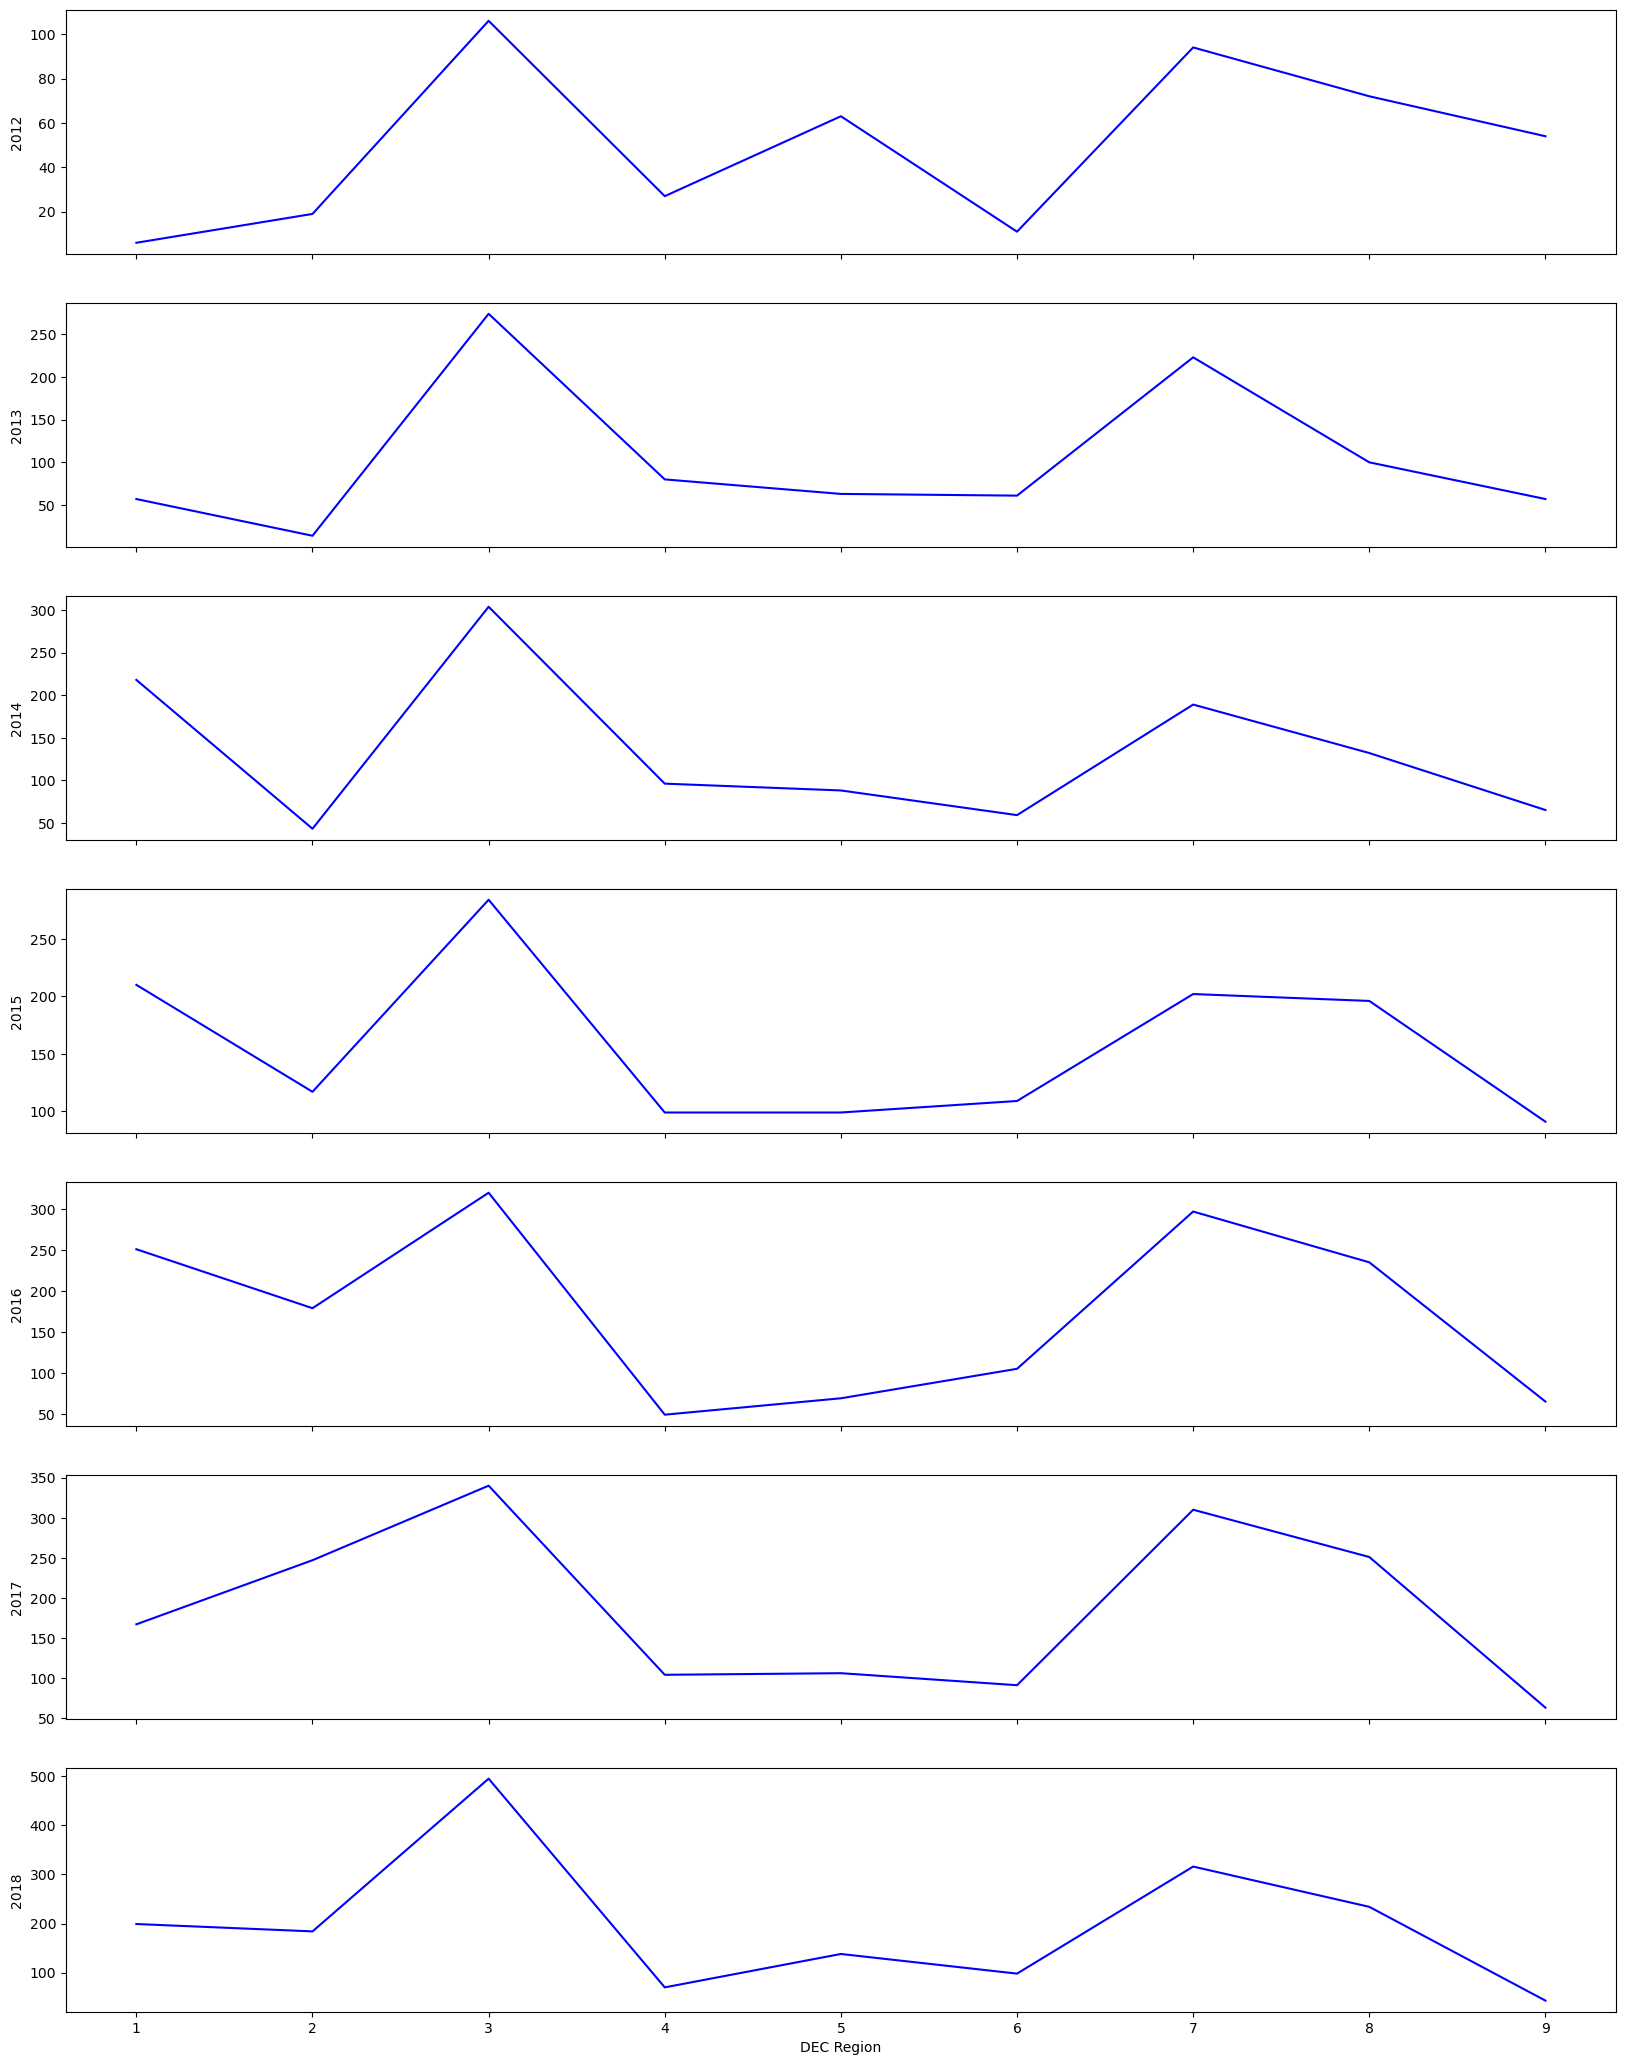

In [7]:
#%% Create multi-panel plot with each DEC region, per year

fig5, (ax15, ax25, ax35, ax45, ax55, ax65, ax75) = plt.subplots(7, 1,figsize = (20,26),sharex= True)

df2012 = yearly_dict[2012]

ax15.plot(df2012['DEC Region'],df2012['Number of Weeks on DEC Notification List'], 'b-', label = '2012')
ax15.set_ylabel('2012')

df2013 = yearly_dict[2013]

ax25.plot(df2013['DEC Region'],df2013['Number of Weeks on DEC Notification List'], 'b-', label = '2013')
ax25.set_ylabel('2013')

df2014 = yearly_dict[2014]

ax35.plot(df2014['DEC Region'],df2014['Number of Weeks on DEC Notification List'], 'b-', label = '2014')
ax35.set_ylabel('2014')

df2015 = yearly_dict[2015]

ax45.plot(df2015['DEC Region'],df2015['Number of Weeks on DEC Notification List'], 'b-', label = '2015')
ax45.set_ylabel('2015')

df2016 = yearly_dict[2016]

ax55.plot(df2016['DEC Region'],df2016['Number of Weeks on DEC Notification List'], 'b-', label = '2016')
ax55.set_ylabel('2016')

df2017 = yearly_dict[2017]

ax65.plot(df2017['DEC Region'],df2017['Number of Weeks on DEC Notification List'], 'b-', label = '2017')
ax65.set_ylabel('2017')

df2018 = yearly_dict[2018]

ax75.plot(df2018['DEC Region'],df2018['Number of Weeks on DEC Notification List'], 'b-', label = '2018')
ax75.set_ylabel('2018')
ax75.set_xlabel('DEC Region')

## Analysis:
-   Some sort of function or other means of seperating the HAB data by lakes, and create a plot w/ multiple subplots showing HAB occurence over time for various lakes

-   Compare the total number of weeks HABs were on DEC watchlists per year, compare increases

-  PLot discharge, precip, and DEC watchlist data, in theory increased precip leads to increased HAB rate, discharge less so indicative of HABs just helpful to see water movement in the area. Can compare trends

-  Plots for monthly HAB occurence by lake and overall, to identify seasonality and any changes within

-  Can use precip and discharge to estimate ET, indicative of energy rates which is another major component of HAB rate

-  Can also add the ET to any of the plots and observe any potential overlaps in the rates
    

## Discussion:
HABs can be toxic to humans, and at the minimum their occurence in drinking water sources can cause shutdowns and inconviences to the public, along with shutting down local recreational areas. Expound on the impacts (economic, social, environmental)

Then can go into detail discussing results. If positive, can identify any potential measures that have been taken in NY or nationally that could potentially explain these (either measure targetting HABS directly, or sources such as energy influx or nutrient influx), these measures also should probably be referenced first in the hypothesis or introduction. If negative, explain why any potential measures aren't working. If no measures were found, try and identify why the results appear negative, and maybe brainstorm any measures that could be taken to deal with the identified apparent cause. If the results are inconclusive (varying or differing rates in HAB occurence, precip, or discharge, for example) explain what is explainable, try to explain reasons why other results may be inconclusive

Regardless of the results, the limitations will need to be discussed. HABs throughout the state of NY were analyzed, but precip and discharge data was only looked at for a single site. These are intended to charecterize the ET and water movement, but there are issues with using it for the whole state. The HAB data only goes back to 2012, and the practices that led to the increase in HAB occurence was very likely before that, so the complete picture on HAB data is likely not available.